## install & load packages

In [37]:
!pip -q install git+https://github.com/mwshinn/PyDDM
import pyddm
import pyddm.plot
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyddm import Sample
import re

## prep data

In [12]:
# Load data - need to manually upload inference_tidy.csv into the files tab on each new runtime
df = pd.read_csv('inference_tidy.csv')
df = df.dropna(subset=['RT'])

# 8 drifts

In [6]:
def eightDrifts(t, trueCongruence, signal1_onset, noise2_onset, signal2_onset,
                      noise1Drift_80, noise1Drift_50, signal1Drift_80, signal1Drift_50,
                      noise2Drift_80, noise2Drift_50, signal2Drift_80, signal2Drift_50):
  # drift rate during first noise period
  if t < signal1_onset:
    if trueCongruence == 'congruent':
      return noise1Drift_80
    elif trueCongruence == 'incongruent':
      return -noise1Drift_80
    else:
      return noise1Drift_50

  # drift rates during first signal period
  if t >= signal1_onset and t < noise2_onset:
    if trueCongruence == 'congruent':
      return signal1Drift_80
    elif trueCongruence == 'incongruent':
      return -signal1Drift_80
    else:
      return signal1Drift_50

  # drift rates during the second noise period
  if t >= noise2_onset and t < signal2_onset:
    if trueCongruence == 'congruent':
      return noise2Drift_80
    elif trueCongruence == 'incongruent':
      return -noise2Drift_80
    else:
      return noise2Drift_50

  # drift rates during the second signal period
  if t >= signal2_onset:
    if trueCongruence == 'congruent':
      return signal2Drift_80
    elif trueCongruence == 'incongruent':
      return -signal2Drift_80
    else:
      return signal2Drift_50

## simple simulation

In [ ]:
# specify model
model = pyddm.gddm(
    drift = eightDrifts,
    starting_position = 0,
    bound="B",
    T_dur = 4.1,
    nondecision='ndt',
    parameters={'B': (0.01, 10), 'ndt': (0.2),
                'noise1Drift_80': (-1, 1), 'noise1Drift_50': (-1,1),
                'signal1Drift_80': (-1, 1), 'signal1Drift_50': (-1, 1),
                'noise2Drift_80': (-1, 1), 'noise2Drift_50': (-1,1),
                'signal2Drift_80': (-1, 1), 'signal2Drift_50': (-1, 1)},
    conditions = ['trueCue', 'trueCongruence', 'coherence', 'signal1_onset', 'noise2_onset', 'signal2_onset']
)


pyddm.plot.model_gui_jupyter(model, conditions={'trueCue': [0.5, 0.8],
                                                'trueCongruence': ['congruent', 'incongruent', 'neutral'],
                                                'signal1_onset': [0.8],
                                                'noise2_onset': [1.2],
                                                'signal2_onset': [2.2]})

## positive values only

In [73]:
# specify model
model = pyddm.gddm(
    drift = eightDrifts,
    starting_position = 0,
    bound="B",
    T_dur = 4.1,
    nondecision='ndt',
    parameters={'B': (0.5, 5), 'ndt': (0.01,1.5),
                'noise1Drift_80': (0, 10), 'noise1Drift_50': (0,10),
                'signal1Drift_80': (0, 10), 'signal1Drift_50': (0, 10),
                'noise2Drift_80': (0, 10), 'noise2Drift_50': (0, 10),
                'signal2Drift_80': (0, 10), 'signal2Drift_50': (0, 10)},
    conditions = ['trueCue', 'trueCongruence', 'coherence', 'signal1_onset', 'noise2_onset', 'signal2_onset']
)

pyddm.plot.model_gui_jupyter(model, sample, data_dt=0.05)

Output()

# plotting fits

In [69]:
subID=38
subject_df = df[df['subID']==subID]
results_file=f's{subID}_results.txt'

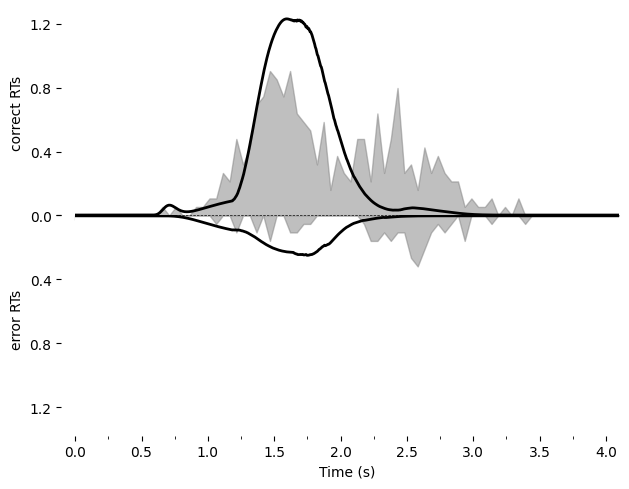

In [72]:
# read in results
with open(results_file, 'r') as f:
          content = f.read()
loss_match = re.search(r'Loss: ([\d\.]+)', content)
loss = float(loss_match.group(1)) if loss_match else None

# extract parameters
params = {}
for name, value in re.findall(r"'([\w_]+)': Fitted\(([\d\.]+)", content):
  params[name] = float(value)

# initialize model & sample
model = pyddm.gddm(drift=eightDrifts,
                     T_dur = 4.1,
                     bound='B',
                     nondecision='nondectime',
                     parameters = params,
                     conditions=['trueCongruence', 'coherence', 'signal1_onset', 'noise2_onset', 'signal2_onset'])

sample = pyddm.Sample.from_pandas_dataframe(subject_df, rt_column_name='RT', choice_column_name='accuracy')
pyddm.plot.plot_fit_diagnostics(model, sample, data_dt=0.05)

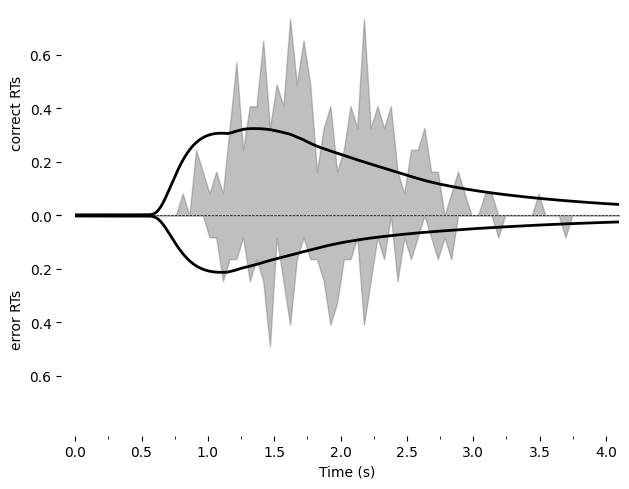

In [51]:
# make plot with noise durations
%matplotlib inline
signal1_onset = subject_df['signal1_onset'].mode()[0]
noise2_onset = subject_df['noise2_onset'].mode()[0]
signal2_onset = subject_df['signal2_onset'].mode()[0]

fig = plt.figure(figsize=(12, 10))

# Add noise regions to each subplot
for ax in fig.get_axes():
  try:
      # First noise period (0 to signal1_onset)
      ax.axvspan(0, signal1_onset, alpha=0.25, color='lightblue')
      # Second noise period (noise2_onset to signal2_onset)
      ax.axvspan(noise2_onset, signal2_onset, alpha=0.25, color='lightblue')

      # Add labels
      ylim = ax.get_ylim()
      ax.text(signal1_onset/2, ylim[1]*0.95, 'Noise 1',
              ha='center', va='top', backgroundcolor='white', alpha=0.7)
      ax.text((noise2_onset + signal2_onset)/2, ylim[1]*0.95, 'Noise 2',
              ha='center', va='top', backgroundcolor='white', alpha=0.7)
  except Exception as e:
      print(f"Warning: Could not add noise regions to a subplot: {e}")

# Create parameter text
param_text = """
Fitted Parameters for Subject {subID} (Loss: {loss:.4f})
Boundary (B): {params.get('bound', 'N/A'):.3f}
Non-decision time: {params.get('nondectime', 'N/A'):.3f}

First Period Drifts:
noise1Drift_80: {params.get('noise1Drift_80', 'N/A'):.3f}  noise1Drift_50: {params.get('noise1Drift_50', 'N/A'):.3f}
signal1Drift_80: {params.get('signal1Drift_80', 'N/A'):.3f}  signal1Drift_50: {params.get('signal1Drift_50', 'N/A'):.3f}

Second Period Drifts:
noise2Drift_80: {params.get('noise2Drift_80', 'N/A'):.3f}  noise2Drift_50: {params.get('noise2Drift_50', 'N/A'):.3f}
signal2Drift_80: {params.get('signal2Drift_80', 'N/A'):.3f}  signal2Drift_50: {params.get('signal2Drift_50', 'N/A'):.3f}

Timing: signal1_onset={signal1_onset:.2f}, noise2_onset={noise2_onset:.2f}, signal2_onset={signal2_onset:.2f}
"""

# Add text box and finalize plot
fig.text(0.5, 0.01, param_text, ha='center', va='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=10, fontfamily='monospace')
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.suptitle(f'Subject {subID} Model Fit', fontsize=16, y=0.98)


pyddm.plot.plot_fit_diagnostics(model, sample, data_dt=0.05)



        # Save and close
        plt.savefig(os.path.join(output_dir, f'subject_{subID}_fit.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Successfully created plot for subject {subID}")

plt.show()